In [185]:
import pandas as pd
import numpy as np


path = '/Users/jonzimmerman/Desktop/Data Projects/Amtrak/data/'
amtrak_df = pd.read_csv(path + 'amtrak_prepped_df.csv')
amtrak_df.shape

(33432, 14)

In [186]:
amtrak_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor


In [187]:
#--- Combine Year and Month
amtrak_df['year_month'] = pd.to_datetime(amtrak_df[['Year', 'Month']].assign(day=1))
amtrak_df['year_month'] = amtrak_df['year_month'].dt.strftime('%Y-%m-%d')

### Step 1: Check for any missing ride #s 

In [188]:
missing = pd.DataFrame(amtrak_df.groupby('station_name')['Rides'].apply(lambda x: x.isna().sum())).reset_index()
missing[missing['Rides']>0]

,station_name,Rides
11,"Arcadia, MO",12
23,"Bellingham, WA",24
108,"Fairfield-Vacaville, CA",24
198,"Lodi, CA",12
208,"Marks, MS",24
230,"Mount Vernon, WA",12
273,"Plattsburhg, NY",24
295,"Roanoke, VA",24
342,"State Street-New Haven, CT",24
343,"Stockton-Downtown, CA",12


### List out info that will be used in imputation process for each station

In [189]:
missing_list = missing[missing['Rides']>0]['station_name'].unique().tolist()
more_info_about_missing_rides = amtrak_df[amtrak_df['station_name'].isin(missing_list)]
missing_inputs = more_info_about_missing_rides[['station_name','abbrev','lat','lon']].drop_duplicates()
missing_inputs

,station_name,abbrev,lat,lon
924,"Arcadia, MO",ACD,37.649536,-90.671728
1932,"Bellingham, WA",BEL,48.720417,-122.511263
9156,"Fairfield-Vacaville, CA",FFV,38.285447,-121.967975
16632,"Lodi, CA",LOD,38.133181,-121.271741
17472,"Marks, MS",MKS,34.258176,-90.272366
19320,"Mount Vernon, WA",MVW,48.417792,-122.334634
22764,"Plattsburhg, NY",PLB,44.696703,-73.446430
24276,"Roanoke, VA",RNK,37.273114,-79.943461
28056,"State Street-New Haven, CT",STS,41.295149,-72.937242
28140,"Stockton-Downtown, CA",SKT,37.955839,-121.278763


## Which years are missing?

In [253]:
stn_code = "SKT"
missing_years = pd.DataFrame(more_info_about_missing_rides[more_info_about_missing_rides['abbrev']==stn_code].groupby('Year')['Rides'].sum()).reset_index()
years_list = missing_years[missing_years['Rides']==0]['Year'].unique().tolist()
years_list

[2021]

### Impute rides based on factor of closest station

In [254]:
# Given latitude and longitude
given_lat = missing_inputs[missing_inputs['abbrev']==stn_code]['lat'].values[0]
given_lon = missing_inputs[missing_inputs['abbrev']==stn_code]['lon'].values[0]

# Function to calculate the Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Filter out same stations
amtrak_df_test = amtrak_df[amtrak_df['abbrev']!=stn_code]

#Remove stations in missing list so we dont use them
amtrak_df_test = amtrak_df_test[~amtrak_df_test['abbrev'].isin(missing_inputs['abbrev'].unique().tolist())]

# Apply the function to calculate distance for each row
amtrak_df_test['Distance'] = amtrak_df_test.apply(lambda row: haversine(given_lat, given_lon, row['lat'], row['lon']), axis=1)

# Find the row with the minimum distance
closest_row = amtrak_df_test.loc[amtrak_df_test['Distance'].idxmin()]


if closest_row['station_name'] in missing_list:
    print(f"{closest_row['station_name']} ({closest_row['abbrev']}) is in the stations with missing rides list.")
else:
    print('Closest station is: ', closest_row['station_name'])
    print('Station Code: ', closest_row['abbrev'])

Closest station is:  Modesto, CA
Station Code:  MOD


In [255]:
# Find factor difference between means of 2 stations - impute missing year adjusted by factor

imp_stn_code = closest_row['abbrev']
org_stn_code = stn_code

denominator = amtrak_df[amtrak_df['abbrev']==imp_stn_code]['Rides'].mean()
numerator = amtrak_df[amtrak_df['abbrev']==org_stn_code]['Rides'].mean()

factor = numerator/denominator
print(f'Avg Rides per month for {imp_stn_code}: ', denominator)
print(f'Avg Rides per month for {org_stn_code}: ', numerator)
print('Factor to adjust imputations: ', factor)

Avg Rides per month for MOD:  7854.761904761905
Avg Rides per month for SKT:  1709.9305555555554
Factor to adjust imputations:  0.21769349297767


In [256]:
imputed_values = amtrak_df[amtrak_df['abbrev']==imp_stn_code][['Year','Month','Rides']]
imputed_values = imputed_values[imputed_values['Year'].isin(years_list)]
imputed_values['Rides'] = imputed_values['Rides']*factor
imputed_values['abbrev'] = org_stn_code
imputed_values

,Year,Month,Rides,abbrev
19044,2021,1,449.319370,SKT
19045,2021,2,673.979054,SKT
19046,2021,3,786.308897,SKT
19047,2021,4,1010.968581,SKT
19048,2021,5,1235.628266,SKT
19049,2021,6,1235.628266,SKT
19050,2021,7,1347.958109,SKT
19051,2021,8,1123.298424,SKT
19052,2021,9,786.308897,SKT
19053,2021,10,673.979054,SKT


In [257]:
# Merge the dataframes on the common columns
amtrak_df = pd.merge(amtrak_df, imputed_values, on=['Year', 'Month', 'abbrev'], how='left', suffixes=('', '_imputed'))

# Replace missing values in 'value' column with values from 'value_impute'
amtrak_df['Rides'] = amtrak_df['Rides'].combine_first(amtrak_df['Rides_imputed'])

# Drop the 'value_impute' column if no longer needed
amtrak_df = amtrak_df.drop(columns=['Rides_imputed'])

In [258]:
# Check missing again
missing = pd.DataFrame(amtrak_df.groupby('station_name')['Rides'].apply(lambda x: x.isna().sum())).reset_index()
missing[missing['Rides']>0]

,station_name,Rides


### Save imputed version of data

In [2]:
#amtrak_df.to_csv('amtrak_df_v2.csv',index=False)

### Reread into notebook

In [1]:
import pandas as pd
import numpy as np
path = '/Users/jonzimmerman/Desktop/Data Projects/Amtrak/data/'
amtrak_df = pd.read_csv(path + 'amtrak_df_v2.csv')
amtrak_df.head(2)

/Users/jonzimmerman/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line,year_month
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-01-01
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-02-01


In [2]:
amtrak_df['parent_route'] = np.where(amtrak_df['parent_route'].isna(), "Other", amtrak_df['parent_route'])
amtrak_df['business_line'] = np.where(amtrak_df['business_line'].isna(), "Other", amtrak_df['business_line'])

In [3]:
amtrak_df['business_line'].value_counts()

business_line
Long Distance         19656
State Supported        7392
Other                  4284
Northeast Corridor     2100
Name: count, dtype: int64

### Create case weights

In [4]:
# Get the most recent time in the dataframe for reference
from datetime import datetime

max_month = amtrak_df['year_month'].max()
date_format = '%Y-%m-%d'
date_object = datetime.strptime(max_month, date_format)
date_object

#Calculate the difference in months between each date in the 'Time' column and the most recent date
months_diff = (date_object.year - amtrak_df['Year']) * 12 + date_object.month - amtrak_df['Month']

# More recent months get higher weights, e.g., weight decreases with the number of months passed
amtrak_df['weight'] = 10 - months_diff
amtrak_df['weight'] = amtrak_df['weight'].clip(lower=1)  # Ensure weights do not go below 1
amtrak_df.head(2)

,Year,Month,Rides,address,state,station_name,abbrev,lat,lon,num_routes,active_routes,active_rides,parent_route,business_line,year_month,weight
0,2016,1,1486.44,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-01-01,1
1,2016,2,2229.66,"18 E Bel Air Ave Aberdeen, MD 21001-3701",MD,"Aberdeen, MD",ABE,39.509437,-76.163827,1,['northeast_regional_route'],[21767995.0],Northeast Regional,Northeast Corridor,2016-02-01,1


### Step 2: Split into training and calibration datasets

In [5]:
cutoff_date = '2021-07-01'

train_df = amtrak_df[amtrak_df['year_month']<cutoff_date]
calib_df = amtrak_df[amtrak_df['year_month']>=cutoff_date]

#Check dimensions
print("TRN set dimensions: ", train_df.shape)
print("CLB set dimensions: ", calib_df.shape)
print('Training set is ', round(train_df.shape[0]/ (train_df.shape[0]+calib_df.shape[0]),2)*100, '% of full data')

TRN set dimensions:  (26268, 16)
CLB set dimensions:  (7164, 16)
Training set is  79.0 % of full data


### Step 3: Fit model to training data

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure 'year_month' is in datetime format
train_df['year_month'] = pd.to_datetime(train_df['year_month'])

# Convert dates to numeric format
train_df['date_num'] = (train_df['year_month'] - train_df['year_month'].min()).dt.days

# Add seasonal component (e.g., month of the year)
train_df['month'] = train_df['year_month'].dt.month

# Define the formula for Poisson regression with seasonal component
formula = 'Rides ~ date_num + C(month)'

# Group the training data by the grouping variable
grouped = train_df.groupby('station_name')

# Prepare a dictionary to store models and future predictions
models = {}
future_predictions = {}

# Forecasting horizon
forecast_horizon = 18

# Fit Poisson regression models for each group and make future predictions
for group_name, group_data in grouped:
    # Fit the model
    model = smf.poisson(formula=formula, data=group_data).fit()

    models[group_name] = model

    # Create future data points for prediction
    last_date_num = group_data['date_num'].max()
    
    future_dates = pd.date_range(start=group_data['year_month'].max() + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
    future_date_num = (future_dates - train_df['year_month'].min()).days
    
    # Add future months to the future data
    future_month = future_dates.month
    
    future_data = pd.DataFrame({
        'date_num': future_date_num,
        'month': future_month
    })

    # Make predictions for the future data points
    future_predictions[group_name] = model.predict(future_data)


Optimization terminated successfully.
         Current function value: 62.321233
         Iterations 7
Optimization terminated successfully.
         Current function value: 714.291847
         Iterations 7
Optimization terminated successfully.
         Current function value: 33.959327
         Iterations 7
Optimization terminated successfully.
         Current function value: 65.602829
         Iterations 7
Optimization terminated successfully.
         Current function value: 3.942051
         Iterations 7
Optimization terminated successfully.
         Current function value: 8.591569
         Iterations 7
Optimization terminated successfully.
         Current function value: 98.370866
         Iterations 7
Optimization terminated successfully.
         Current function value: 15.980759
         Iterations 7
Optimization terminated successfully.
         Current function value: 7.829126
         Iterations 7
Optimization terminated successfully.
         Current function value: 480.

Optimization terminated successfully.
         Current function value: 29.760437
         Iterations 7
Optimization terminated successfully.
         Current function value: 27.659460
         Iterations 7
Optimization terminated successfully.
         Current function value: 8.305843
         Iterations 7
Optimization terminated successfully.
         Current function value: 95.808466
         Iterations 7
Optimization terminated successfully.
         Current function value: 17.672867
         Iterations 7
Optimization terminated successfully.
         Current function value: 57.907921
         Iterations 7
Optimization terminated successfully.
         Current function value: 28.957621
         Iterations 7
Optimization terminated successfully.
         Current function value: 124.581754
         Iterations 7
Optimization terminated successfully.
         Current function value: 381.478578
         Iterations 7
Optimization terminated successfully.
         Current function value: 5

Optimization terminated successfully.
         Current function value: 35.136622
         Iterations 7
Optimization terminated successfully.
         Current function value: 21.219910
         Iterations 7
Optimization terminated successfully.
         Current function value: 23.183600
         Iterations 7
Optimization terminated successfully.
         Current function value: 27.493440
         Iterations 7
Optimization terminated successfully.
         Current function value: 39.637013
         Iterations 7
Optimization terminated successfully.
         Current function value: 3.400027
         Iterations 7
Optimization terminated successfully.
         Current function value: 2417.990269
         Iterations 7
Optimization terminated successfully.
         Current function value: 36.739378
         Iterations 7
Optimization terminated successfully.
         Current function value: 49.091022
         Iterations 7
Optimization terminated successfully.
         Current function value: 3

Optimization terminated successfully.
         Current function value: 324.991127
         Iterations 7
Optimization terminated successfully.
         Current function value: 153.509525
         Iterations 7
Optimization terminated successfully.
         Current function value: 8.171655
         Iterations 7
Optimization terminated successfully.
         Current function value: 9.673945
         Iterations 7
Optimization terminated successfully.
         Current function value: 224.351428
         Iterations 7
Optimization terminated successfully.
         Current function value: 531.276691
         Iterations 7
Optimization terminated successfully.
         Current function value: 667.447210
         Iterations 7
Optimization terminated successfully.
         Current function value: 270.681336
         Iterations 7
Optimization terminated successfully.
         Current function value: 143.795059
         Iterations 7
Optimization terminated successfully.
         Current function valu

### Step 3a: Plot some predictions

In [22]:
start_date = '2021-07-01'
end_date = '2022-12-01'
future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

future_dates_list = future_dates.strftime('%Y-%m-%d').tolist()

# Arrange the predictions in the same structure as the original data
dict_df = pd.DataFrame(future_predictions)
preds = pd.melt(dict_df, var_name='station_name', value_name='Rides')


# Number of stations
num_stns = len(preds['station_name'].unique())

# Create a DataFrame with the date list repeated for each city
date_series = pd.Series(future_dates_list * num_stns)

# Add the date column to the original DataFrame
preds['year_month'] = date_series.values

preds


,station_name,Rides,year_month
0,"Aberdeen, MD",2690.885393,2021-07-01
1,"Aberdeen, MD",2242.404494,2021-08-01
2,"Aberdeen, MD",1570.247228,2021-09-01
3,"Aberdeen, MD",1345.442697,2021-10-01
4,"Aberdeen, MD",1794.568260,2021-11-01
...,...,...,...
7159,"Yonkers, NY",2503.411664,2022-08-01
7160,"Yonkers, NY",1752.468182,2022-09-01
7161,"Yonkers, NY",1502.046998,2022-10-01
7162,"Yonkers, NY",2002.820779,2022-11-01


In [23]:
preds['key'] = 'Predictions'

actuals = amtrak_df[['station_name','Rides','year_month']]
actuals = actuals[actuals['year_month']>=cutoff_date]
#actuals['year_month'] = actuals['year_month'].dt.date
actuals

actuals['key'] = "Actuals"

plot_df = pd.concat([actuals,preds])

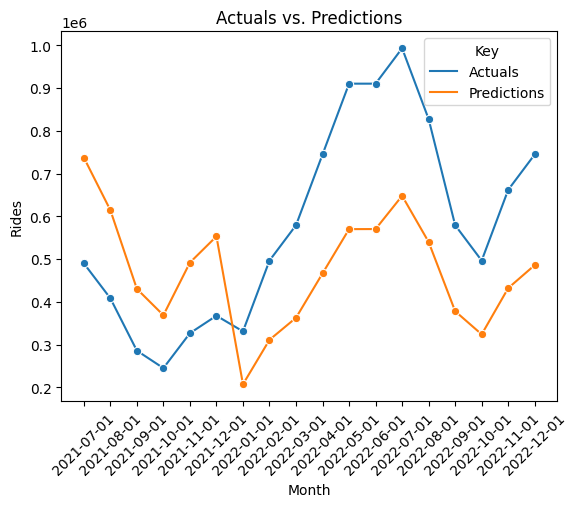

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
stn_filtered_data = plot_df[plot_df['station_name']=="New York, NY"]
                            
sns.lineplot(data=stn_filtered_data, x='year_month', y='Rides', hue='key', marker='o')

#Show the plot
plt.title('Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()


### Let's look at aggregated forecasts for routes and business lines

In [10]:
lines_routes = amtrak_df[['station_name','business_line','parent_route']].drop_duplicates()
full_df = pd.merge(plot_df, lines_routes, on='station_name', how='left')
print('Dataset 1 Dimensions: ', plot_df.shape)
print('Dataset 2 Dimensions: ', lines_routes.shape)
print('Final Dataset Dimensions: ', full_df.shape)

Dataset 1 Dimensions:  (14328, 4)
Dataset 2 Dimensions:  (398, 3)
Final Dataset Dimensions:  (14328, 6)


In [11]:
full_df['parent_route'].unique()

array(['Northeast Regional', 'Coast Starlight', 'Lake Shore',
       'Southwest Chief', 'Cardinal', 'Sunset Limited',
       'Missouri River Runner', 'Pennsylvanian', 'Maple Leaf',
       'Pacific Surliner', 'San Joaquins', 'Other', 'Keystone',
       'Heartland Flyer', 'Crescent', 'Capital Corridor', 'Wolverine',
       'Cascades', 'Empire Builder', 'City Of New Orleans', 'Downeaster',
       'Carolian', 'California Zephyr', 'Lincoln', 'Ethan Allen',
       'Capital Limited', 'Silver Meteor', 'Blue Water', 'Palmetto',
       'Illini Saluki', 'Pere Marquette', 'Carl Sandburg', 'Hiawatha'],
      dtype=object)

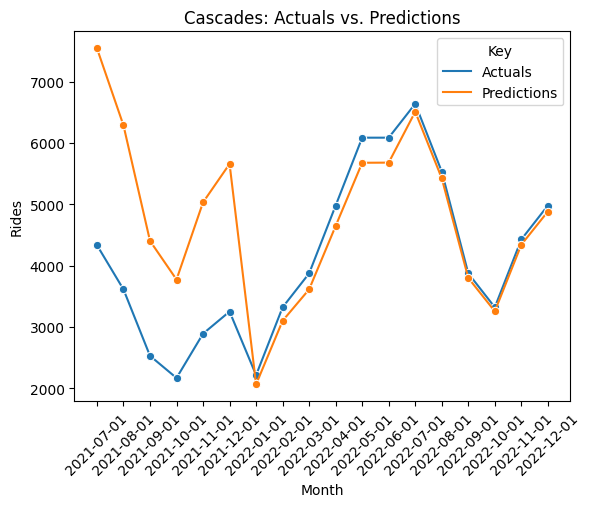

In [12]:
route_data = full_df[full_df['parent_route']=="Cascades"]
name = route_data['parent_route'].unique()[0]

route_data = pd.DataFrame(route_data.groupby(['year_month','key'])['Rides'].sum()).reset_index()

sns.lineplot(data=route_data, x='year_month', y='Rides', hue='key', marker='o')
#Show the plot
plt.title(f'{name}: Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()


In [13]:
full_df['business_line'].unique()

array(['Northeast Corridor', 'Long Distance', 'State Supported', 'Other'],
      dtype=object)

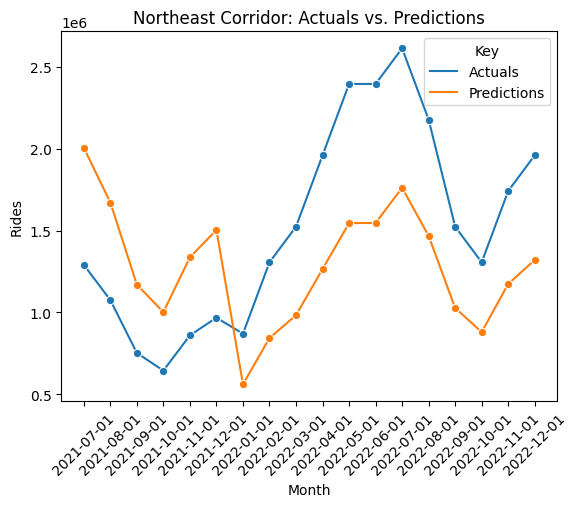

In [14]:
bus_line_data = full_df[full_df['business_line']=="Northeast Corridor"]
name = bus_line_data['business_line'].unique()[0]

bus_line_data = pd.DataFrame(bus_line_data.groupby(['year_month','key'])['Rides'].sum()).reset_index()

sns.lineplot(data=bus_line_data, x='year_month', y='Rides', hue='key', marker='o')

#Show the plot
plt.title(f'{name}: Actuals vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Rides')
plt.legend(title='Key')
plt.xticks(rotation=45) 

plt.show()

### Step 3b: Diagnostics

### Step 4: Run model on calibration set

### Step 4a: Plot some predictions


### Step 4b: Diagnostics

### Step 5: Refit model with all data